In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")

from AnalysisTables.cross_correlation import (

    CrossCorrelogramParameters,
    CrossCorrelogramSelection,
    CrossCorrelogram,
)
from AnalysisTables.ripples import RippleIntervals
from AnalysisTables.place_fields import OptoPlaceField, PlaceFieldCoverage
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from spyglass.common import PositionIntervalMap, TaskEpoch
from Style.style_guide import interval_style, animal_style

import numpy as np
import pandas as pd
from tqdm import tqdm


[2025-02-07 10:48:10,396][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-02-07 10:48:10,428][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [2]:
CrossCorrelogramParameters()  # .alter()

cross_corr_params_name,interval_buffer,filter_speed,filter_port,min_run_time,gauss_smooth,max_lag,closest_spike_only,dlc_position,exclude_simultaneous
all_times,0.0,0.0,0,0.0,0.003,1,0,0,0
default,0.0,10.0,1,0.5,0.003,1,0,0,0
default_dlc,0.0,10.0,1,0.5,0.003,1,0,1,0
default_dlc_no_simultaneous,0.0,10.0,1,0.5,0.003,1,0,1,1
default_no_simultaneous,0.0,10.0,1,0.5,0.003,1,0,0,1


# Populate

In [3]:
CrossCorrelogramParameters()  # .insert_default()

for name in ["default", "default_dlc"]:
    params = (CrossCorrelogramParameters() & {"cross_corr_params_name": name}).fetch1()
    params["cross_corr_params_name"] = name + "_no_simultaneous"
    params["exclude_simultaneous"] = True
    CrossCorrelogramParameters().insert1(params, skip_duplicates=True)

    old_entry = (CrossCorrelogramSelection() & {"cross_corr_params_name": name}).fetch(
        "KEY"
    )
    new_entries = []
    for key in old_entry:
        key["cross_corr_params_name"] = (
            key["cross_corr_params_name"] + "_no_simultaneous"
        )
        new_entries.append(key)
    CrossCorrelogramSelection().insert(new_entries, skip_duplicates=True)

In [4]:
from Analysis.utils import filter_opto_data
from Style.style_guide import animal_style
from spyglass.common import convert_epoch_interval_name_to_position_interval_name

animal = "Winnie"
params_name = "default_dlc"

animal_list = animal_style.index
for animal in animal_list:
    dataset_key = {
        # "animal": animal,
        # "targeted_phase": 90,
        "track_type": "early_wtrack",
        "min_pulse_length": 20,
        # "period_ms":100
    }
    dataset = filter_opto_data(dataset_key)
    dataset = dataset & "period_ms >10"
    corr_key = None
    for nwb_file_name, pos_interval_name in zip(
        *dataset.fetch("nwb_file_name", "interval_list_name")
    ):
        # if not "nwb_file_name" == "Winnie20220719_.nwb":
        #     continue
        map_key = {
            "nwb_file_name": nwb_file_name,
            "position_interval_name": pos_interval_name,
        }
        epoch_interval = ((PositionIntervalMap() & map_key) * TaskEpoch).fetch1(
            "interval_list_name"
        )
        for interval in [
            pos_interval_name,
        ]:  # pos_interval_name + "_opto_control_interval", pos_interval_name + "_opto_test_interval"]:

            try:
                convert_epoch_interval_name_to_position_interval_name(
                    {"nwb_file_name": nwb_file_name, "interval_list_name": interval}
                )
            except:
                continue

        spikes_key = SortedSpikesGroup() & {
            "nwb_file_name": nwb_file_name,
            "sorted_spikes_group_name": epoch_interval,
            "unit_filter_params_name": "default_exclusion",
        }
        if not spikes_key:
            continue
        spikes_key = spikes_key.fetch1("KEY")

        corr_key = [
            {
                **spikes_key,
                "interval_list_name": pos_interval_name,
                "cross_corr_params_name": params_name,
            }
        ]
        corr_key.append(
            {
                **spikes_key,
                "interval_list_name": pos_interval_name + "_opto_control_interval",
                "cross_corr_params_name": params_name,
            }
        )
        corr_key.append(
            {
                **spikes_key,
                "interval_list_name": pos_interval_name + "_opto_test_interval",
                "cross_corr_params_name": params_name,
            }
        )

        # ripple times
        if query := (
            (RippleIntervals & {"nwb_file_name": nwb_file_name})
            & f"target_interval_list_name LIKE '%{pos_interval_name}%'"
        ):
            ripple_interval = query.fetch1("ripple_interval_list_name")
            corr_key.append(
                {
                    **spikes_key,
                    "interval_list_name": ripple_interval,
                    "cross_corr_params_name": "all_times",
                }
            )

        CrossCorrelogramSelection().insert(corr_key, skip_duplicates=True)
CrossCorrelogramSelection() - CrossCorrelogram()
# CrossCorrelogram().populate(corr_key, processes=1, suppress_errors=False)

datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86
datasets: 86


nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,interval_list_name descriptive name of this interval list,cross_corr_params_name
Bilbo20230725_.nwb,default_exclusion,10_lineartrack,pos 9 valid times,default
Bilbo20230725_.nwb,default_exclusion,10_lineartrack,pos 9 valid times,default_no_simultaneous
Bilbo20230725_.nwb,default_exclusion,10_lineartrack,pos 9 valid times_opto_control_interval,default
Bilbo20230725_.nwb,default_exclusion,10_lineartrack,pos 9 valid times_opto_control_interval,default_no_simultaneous
Bilbo20230725_.nwb,default_exclusion,10_lineartrack,pos 9 valid times_opto_test_interval,default
Bilbo20230725_.nwb,default_exclusion,10_lineartrack,pos 9 valid times_opto_test_interval,default_no_simultaneous
Frodo20230808_.nwb,default_exclusion,12_lineartrack,pos 11 valid times,default
Frodo20230808_.nwb,default_exclusion,12_lineartrack,pos 11 valid times,default_no_simultaneous
Frodo20230808_.nwb,default_exclusion,12_lineartrack,pos 11 valid times_opto_control_interval,default
Frodo20230808_.nwb,default_exclusion,12_lineartrack,pos 11 valid times_opto_control_interval,default_no_simultaneous


In [4]:
sel = CrossCorrelogramSelection() - CrossCorrelogram()
sel

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,interval_list_name descriptive name of this interval list,cross_corr_params_name
Bilbo20230724_.nwb,default_exclusion,04_lineartrack,pos 3 valid times,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,04_lineartrack,pos 3 valid times_opto_control_interval,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,04_lineartrack,pos 3 valid times_opto_test_interval,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,06_lineartrack,pos 5 valid times,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,06_lineartrack,pos 5 valid times_opto_control_interval,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,06_lineartrack,pos 5 valid times_opto_test_interval,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,08_lineartrack,pos 7 valid times,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,08_lineartrack,pos 7 valid times_opto_control_interval,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,08_lineartrack,pos 7 valid times_opto_test_interval,default_no_simultaneous
Bilbo20230724_.nwb,default_exclusion,12_lineartrack,pos 11 valid times,default_no_simultaneous


In [5]:
{"nwb_file_name": nwb_file_name, "interval_list_name": interval}

{'nwb_file_name': 'Yoshi20220510_.nwb',
 'interval_list_name': 'pos 9 valid times'}

In [ ]:
CrossCorrelogram.populate(processes=32, suppress_errors=True)

In [9]:
%debug

> /home/sambray/Documents/spyglass/src/spyglass/common/common_behav.py(649)convert_epoch_interval_name_to_position_interval_name()
    647         pos_query = PositionIntervalMap & key
    648 
--> 649     if pos_query.fetch(pos_str)[0] == "":
    650         logger.info(f"No position intervals found for {key}")
    651         return []

{'nwb_file_name': 'Bilbo20230725_.nwb', 'interval_list_name': 'pos 7 valid times_opto_control_interval'}


In [7]:
from AnalysisTables.ripples import RippleIntervals

print(nwb_file_name)
(
    RippleIntervals & {"nwb_file_name": nwb_file_name}
) & f"target_interval_list_name LIKE '%{pos_interval_name}%'"

Bilbo20230802_.nwb


lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,group_name,ripple_param_name a name for this set of parameters,pos_merge_id,ripple_interval_list_name descriptive name of this interval list
ea1752a4-4e2e-22c4-a35a-c38eaac06f33,Ripple 150-250 Hz,1000,Bilbo20230802_.nwb,Bilbo20230802_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,default_ms,1d583bac-42f5-8e4d-3e95-f7240ef5f87c,Bilbo20230802_.nwb_pos 9 valid times_LFP_default_difference_ripple_times


In [16]:
# from spyglass.position.v1 import DLCPosV1

# # from
# # DLCPosV1() & {"nwb_file_name":nwb_file_name}
# nwb_file_name
# # key = {"nwb_file_name": "Winnie20220719_.nwb"}
# key = True
# DLCPosV1() & key
# CrossCorrelogram().populate(key, processes=30, suppress_errors=True)

In [17]:
nwb_file_name, pos_interval_name
PositionIntervalMap() & map_key
((PositionIntervalMap() & map_key) * TaskEpoch)
# SortedSpikesGroup() & {"nwb_file_name": nwb_file_name,}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,epoch the session epoch for this task and apparatus(1 based),position_interval_name name of the corresponding interval,task_name,camera_name,task_environment the environment the animal was in,camera_names list of keys corresponding to entry in CameraDevice
Bilbo20230726_.nwb,02_lineartrack,2,pos 1 valid times,Lineartrack,None,Lineartrack,=BLOB=


# Cross-correlogram

In [4]:
import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")

from AnalysisTables.cross_correlation import (
    CrossCorrelogramParameters,
    CrossCorrelogramSelection,
    CrossCorrelogram,
)
from AnalysisTables.place_fields import OptoPlaceField

# CrossCorrelogram().populate()  # corr_key)

In [ ]:
from Analysis.utils import filter_opto_data

track = "early_wtrack"
track = "lineartrack"
exclude_simultaneous = True
dlc_pos = track != "lineartrack"
animal = "transfected"
animal = "control"
# animal = "Winnie"
params_name = f"default{'_dlc'*dlc_pos}{'_no_simultaneous'*exclude_simultaneous}"
# params_name = "default"
# dlc_pos = "dlc" in params_name

dataset_key = {
    "animal": animal,
    "targeted_phase": 90,
    "track_type": track,
    "min_pulse_length": 20,
    "laser_power": 77,
}
dataset = filter_opto_data(dataset_key)
dataset = dataset.fetch(as_dict=True)  # [2:4]
control_dataset = []
test_dataset = []
for key in dataset:
    control_dataset.append(
        {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": key["interval_list_name"] + "_opto_control_interval",
            "cross_corr_params_name": params_name,
        }
    )
    test_dataset.append(
        {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": key["interval_list_name"] + "_opto_test_interval",
            "cross_corr_params_name": params_name,
        }
    )


CrossCorrelogram() & control_dataset
control_df = (CrossCorrelogram() & control_dataset).fetch_dataframe()
test_df = (CrossCorrelogram() & test_dataset).fetch_dataframe()
# control_df

datasets: 7


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535:

In [6]:
os.environ["JAX_PLATFORM_NAME"] = "cpu"
distance_condition = "test"
# coverage_condition = "test"
coverage_thresh = 60


if distance_condition == "control":
    coverage_query = (
        PlaceFieldCoverage() & control_dataset & {"unit_coverage_params_name": "50"}
    )
elif distance_condition == "test":
    coverage_query = (
        PlaceFieldCoverage() & test_dataset & {"unit_coverage_params_name": "50"}
    )
coverage_query
if dlc_pos:
    coverage_query = coverage_query & "decode_group_name LIKE '%dlc%'"
else:
    coverage_query = coverage_query - "decode_group_name LIKE '%dlc%'"
coverage_query
coverage_df = (coverage_query & {"unit_coverage_params_name": "50"}).fetch_dataframe()


# TODO: improve restriction of interval
place_table = OptoPlaceField() & dataset
if dlc_pos:
    place_table = place_table & "decode_group_name LIKE '%dlc%'"
else:
    place_table = place_table - "decode_group_name LIKE '%dlc%'"
place_table

distance_df = None
for place_key in tqdm(place_table.fetch("KEY")):

    place_df = (place_table & place_key).fetch_dataframe()
    # peak_place = np.vstack(place_df.place_field).argmax(axis=1)
    peak_place = [np.argmax(x) for x in place_df.place_field]
    place_df = place_df.assign(peak_place=peak_place)
    place_df = place_df.merge(coverage_df, on=["unit_id", "condition"])
    # Filter place_df based on the distance_condition
    # print(len(place_df))
    place_df = place_df[place_df.condition == distance_condition]
    # print(len(place_df))
    place_df = place_df[place_df.coverage < coverage_thresh]
    # print(len(place_df))
    assert (
        place_df.duplicated(subset=["unit_id", "condition"]).sum() == 0
    )  # "duplicates in place_df")
    # Create a cross join (cartesian product) of place_df with itself

    cross_joined_df = (
        place_df.assign(key=1)
        .merge(place_df.assign(key=1), on="key", suffixes=("_1", "_2"))
        .drop(columns="key")
    )

    # Calculate the absolute distance between peak_place values
    from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1

    k = (ClusterlessDecodingV1() & place_key).fetch("KEY", limit=1)[0]
    # model = (ClusterlessDecodingV1() & k).fetch_model()
    # distance_dict = model.environments[0].distance_between_nodes_
    environment = (ClusterlessDecodingV1() & k).fetch_environments(k)[0]
    distance_dict = environment.distance_between_nodes_

    distances = [
        distance_dict[x][y]
        for x, y in zip(cross_joined_df.peak_place_1, cross_joined_df.peak_place_2)
    ]
    cross_joined_df["distance"] = distances

    # Select the relevant columns
    distance_df_i = cross_joined_df[["unit_id_1", "unit_id_2", "distance"]]
    distance_df = (
        distance_df_i
        if distance_df is None
        else pd.concat([distance_df, distance_df_i])
    )
    # break

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:535:

#### Look at change in cross corrrelation vs distance
**TODO**
-Units; normalize by firing rate in the calculated interval to get a correlation

/tmp/ipykernel_313073/2394503216.py:90: RuntimeWarning: All-NaN slice encountered
  val_control = val_control / np.nanmax(val_control[:], axis=1)[:, None]
/tmp/ipykernel_313073/2394503216.py:91: RuntimeWarning: All-NaN slice encountered
  val_test = val_test / np.nanmax(val_test[:], axis=1)[:, None]
100%|██████████| 10/10 [00:00<00:00, 27.12it/s]


Text(0.5, 0.98, "{'animal': 'control', 'targeted_phase': 90, 'track_type': 'lineartrack', 'min_pulse_length': 20, 'laser_power': 77}")

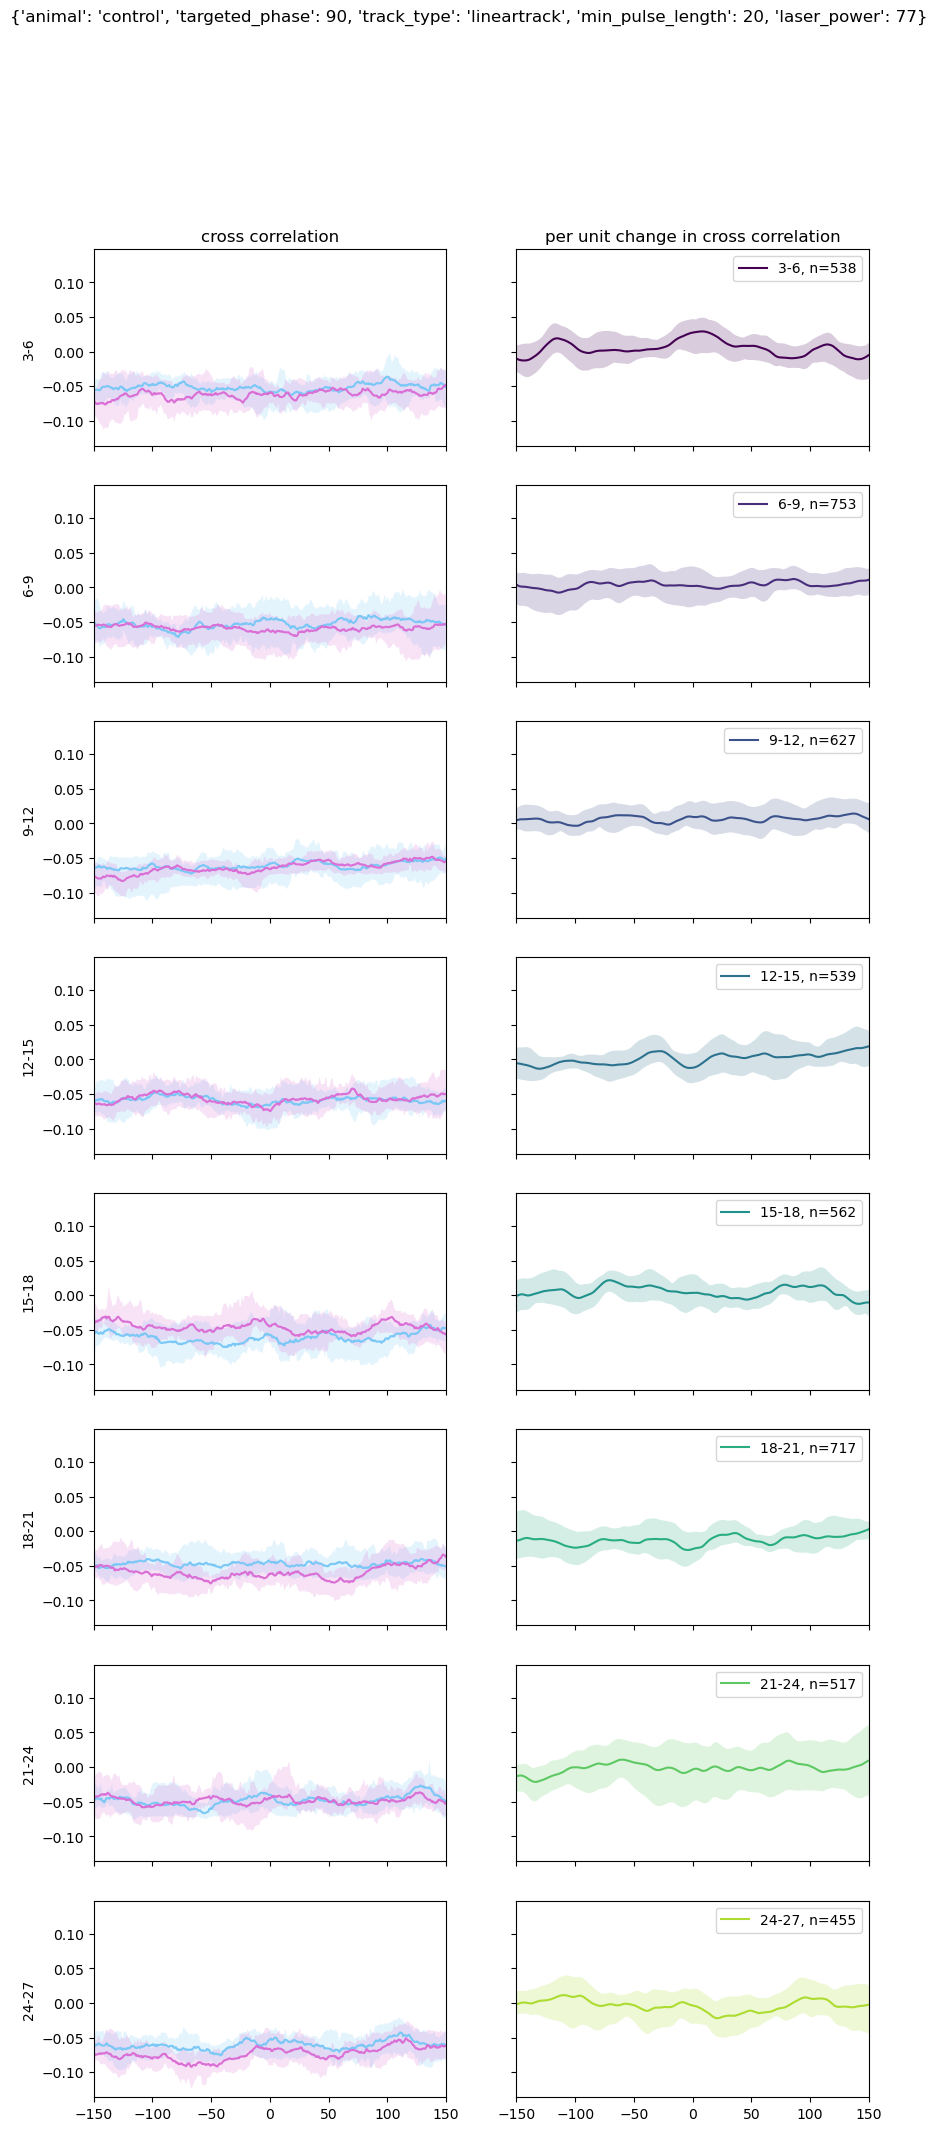

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from Analysis.utils import smooth, bootstrap_traces, bootstrap_diff
from Analysis.spiking_crosscorrelegram import (
    find_peaks,
    boxcar_filter_set,
)

min_spikes = 100
max_spikes = 30000
smooth_w = 60
n_boot = 10
view = 150
hamming = False
sigma = 30

distance_bins = np.arange(1, 60, 10)
distance_bins = np.arange(1, 10, 1)
distance_bins = np.arange(3, 30, 3)
# distance_bins = np.array([5,20])
# distance_bins = np.array([5,15,25])
# distance_bins = np.array([9.9, 15.01])
# distance_bins = np.array([20, 40])

bins = control_df.bins.values[0] * 1000
ind = np.where(np.logical_and(bins > -view, bins < view))[0]

# distance_bins = np.arange(-10, 10, 2)
exclude_auto = True


fig, ax = plt.subplots(
    distance_bins.size - 1,
    2,
    figsize=(10, 3 * (distance_bins.size - 1)),
    sharex=True,
    sharey=True,
)
if len(ax.shape) == 1:
    ax = ax[None, :]


query = (
    f"counts_1 > {min_spikes} and counts_1 < {max_spikes}"
    + f" and counts_2 > {min_spikes} and counts_2 < {max_spikes}"
)

# Apply the query to filter the DataFrame
filtered_control_df = control_df.query(query)

# Filter test_df in advance to reduce the size of the DataFrame for merging
filtered_test_df = test_df.query(query)

# Merge control_plot_df with filtered_test_df based on unit_id_1 and unit_id_2
merged_df = filtered_control_df.merge(
    filtered_test_df,
    on=["unit_id_1", "unit_id_2"],
    suffixes=("_control", "_test"),
    how="inner",
)
base_merged_df = merged_df.merge(distance_df, on=["unit_id_1", "unit_id_2"])
if exclude_auto:
    base_merged_df = base_merged_df.query("unit_id_1 != unit_id_2")


for i in range(distance_bins.size - 1):
    min_distance = distance_bins[i]
    max_distance = distance_bins[i + 1]
    merged_df = base_merged_df.query(
        f"distance >= {min_distance} and distance <= {max_distance}"
    )

    # Calculate the differences using vectorized operations
    val_control = np.vstack(merged_df["correlogram_control"])
    val_test = np.vstack(merged_df["correlogram_test"])

    val_control = smooth(val_control.T, n=smooth_w, sigma=sigma, hamming=hamming).T
    val_test = smooth(val_test.T, n=smooth_w, sigma=sigma, hamming=hamming).T

    # val_control[~np.isfinite(val_control)] = np.nan
    # val_test[~np.isfinite(val_test)] = np.nan
    # val_control = val_control / np.nanmean(val_control, axis=1)[:, None]
    # val_test = val_test / np.nanmean(val_test, axis=1)[:, None]

    val_control = val_control - np.nanmean(val_control, axis=1)[:, None]
    val_test = val_test - np.nanmean(val_test, axis=1)[:, None]
    val_control[~np.isfinite(val_control)] = np.nan
    val_test[~np.isfinite(val_test)] = np.nan
    val_control = val_control / np.nanmax(val_control[:], axis=1)[:, None]
    val_test = val_test / np.nanmax(val_test[:], axis=1)[:, None]

    # val_control = boxcar_filter_set(val_control.T, 200, "divide").T
    # val_test = boxcar_filter_set(val_test.T, 200, "divide").T

    from Analysis.utils import bootstrap_compare

    diffs, (diff_lo, diff_hi) = bootstrap_compare(
        val_test,
        val_control,
        operator=lambda x, y: x - y,
        statistic=lambda x: np.nanmean(x, axis=0),
        n_boot=n_boot,
    )
    color = plt.cm.viridis(i / (distance_bins.size - 1))
    ax[i, 1].plot(
        bins,
        diffs,
        label=f"{min_distance}-{max_distance}, n={val_control.shape[0]}",
        color=color,
    )
    ax[i, 1].fill_between(
        bins,
        diff_lo,
        diff_hi,
        alpha=0.2,
        facecolor=color,
    )

    for distance_condition, val in zip(["control", "test"], [val_control, val_test]):
        color = interval_style[distance_condition]
        # ax[i, 0].plot(
        #     bins,
        #     np.nanmean(val, axis=0),
        #     label=f"{min_distance}-{max_distance}, n={diffs.shape[0]}",
        #     color=color,
        # )
        # ax[i, 0].fill_between(
        #     bins,
        #     np.nanpercentile(val, 25, axis=0),
        #     np.nanpercentile(val, 75, axis=0),
        #     alpha=0.2,
        #     facecolor=color,
        # )
        yy, (lo, hi) = bootstrap_traces(
            val[:, ind], 100, statistic=np.nanmedian, n_boot=n_boot
        )
        ax[i, 0].plot(
            bins[ind],
            yy,
            label=f"{min_distance}-{max_distance}, n={val_control.shape[0]}",
            color=color,
        )
        ax[i, 0].fill_between(
            bins[ind],
            lo,
            hi,
            alpha=0.2,
            facecolor=color,
        )

    ax[i, 0].set_ylabel(f"{min_distance}-{max_distance}")
    ax[i, 1].legend(loc="upper right")


plt.legend()
plt.xlim(-view, view)

# plt.xlim(-50, 50)

# ax.axvline(0, color="k", linestyle=":",zorder=-1)
# ax.axhline(0, color="k", linestyle=":",zorder=-1)

# ax[0, 1].set_ylim(-0.3, 0.3)
# ax[0, 0].set_ylim(.9,1.05)

ax[0, 0].set_title("cross correlation")
ax[0, 1].set_title("per unit change in cross correlation")
fig.suptitle(dataset_key)

In [191]:
val_control.shape

(134, 3999)

In [123]:
distance_df

,unit_id_1,unit_id_2,distance
0,085697a2-f46a-7c9e-cc89-7aad17801577_1,085697a2-f46a-7c9e-cc89-7aad17801577_1,0.000000
1,085697a2-f46a-7c9e-cc89-7aad17801577_1,085697a2-f46a-7c9e-cc89-7aad17801577_2,85.656056
2,085697a2-f46a-7c9e-cc89-7aad17801577_1,085697a2-f46a-7c9e-cc89-7aad17801577_3,82.699781
3,085697a2-f46a-7c9e-cc89-7aad17801577_1,085697a2-f46a-7c9e-cc89-7aad17801577_4,94.524878
4,085697a2-f46a-7c9e-cc89-7aad17801577_1,085697a2-f46a-7c9e-cc89-7aad17801577_5,76.787233
...,...,...,...
12764,e9400951-7119-ea40-e1d5-2539b43cc8dd_8,df14bb23-55ff-e828-6c4c-b913b0a2580d_1,0.000000
12765,e9400951-7119-ea40-e1d5-2539b43cc8dd_8,e9400951-7119-ea40-e1d5-2539b43cc8dd_4,0.000000
12766,e9400951-7119-ea40-e1d5-2539b43cc8dd_8,e9400951-7119-ea40-e1d5-2539b43cc8dd_5,0.000000
12767,e9400951-7119-ea40-e1d5-2539b43cc8dd_8,e9400951-7119-ea40-e1d5-2539b43cc8dd_7,41.263513


(array([1.7114e+04, 2.9550e+03, 3.5990e+03, 3.3970e+03, 3.1720e+03,
        3.1860e+03, 2.7160e+03, 2.2990e+03, 1.8710e+03, 1.4600e+03,
        1.3210e+03, 1.0730e+03, 1.0330e+03, 7.5400e+02, 6.8900e+02,
        5.5700e+02, 5.9500e+02, 4.9800e+02, 3.9600e+02, 3.5600e+02,
        3.3100e+02, 2.9900e+02, 2.5700e+02, 2.1700e+02, 2.1200e+02,
        1.4400e+02, 1.8100e+02, 1.8800e+02, 1.8700e+02, 1.5600e+02,
        1.3100e+02, 1.4300e+02, 1.3000e+02, 1.0900e+02, 1.2800e+02,
        1.2200e+02, 9.5000e+01, 9.5000e+01, 8.2000e+01, 1.1900e+02,
        1.1300e+02, 1.1100e+02, 8.6000e+01, 7.7000e+01, 5.4000e+01,
        5.3000e+01, 6.1000e+01, 4.6000e+01, 6.1000e+01, 5.0000e+01,
        3.7000e+01, 4.4000e+01, 2.7000e+01, 4.4000e+01, 3.1000e+01,
        2.9000e+01, 2.5000e+01, 2.4000e+01, 1.6000e+01, 2.4000e+01,
        2.1000e+01, 1.5000e+01, 1.9000e+01, 1.1000e+01, 1.4000e+01,
        1.9000e+01, 1.1000e+01, 1.4000e+01, 1.0000e+01, 2.2000e+01,
        4.0000e+00, 6.0000e+00, 7.0000e+00, 1.00

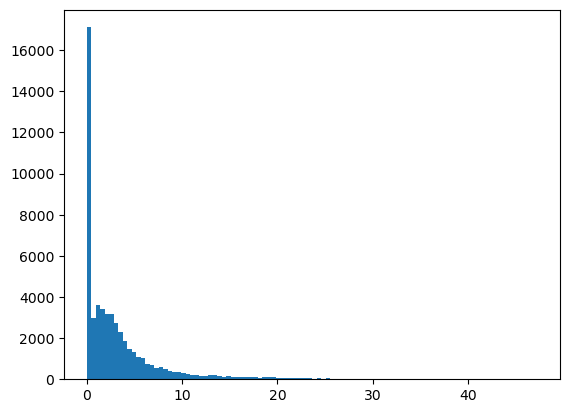

In [125]:
val_control = np.vstack(merged_df["correlogram_control"])
ind = np.where(np.logical_and(bins > -100, bins < 100))
counts = np.nansum(val_control[:, ind], axis=1)
counts = counts[np.isfinite(counts)]
plt.hist(counts, bins=100)

### Peak correlation

In [76]:
np.mean(np.diff(bins))

0.49999999999994493

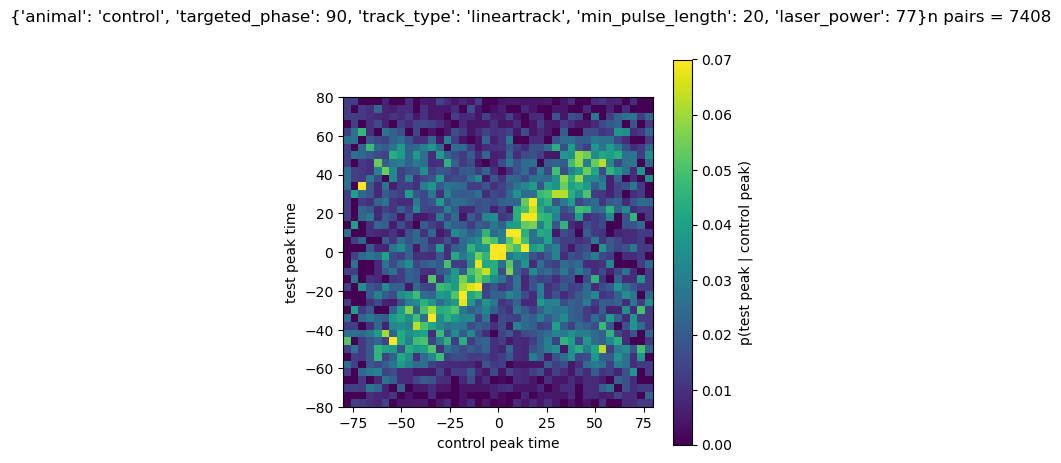

In [12]:
from Analysis.spiking_crosscorrelegram import (
    find_peaks,
    boxcar_filter_set,
)  # ,closest_peak

peak_width = 200
smooth_w = peak_width * 2
min_spikes = 100
max_spikes = 3000

min_distance = 0
max_distance = 500
exclude_auto = True
plot_log = False


query = (
    f"counts_1 > {min_spikes} and counts_1 < {max_spikes}"
    + f" and counts_2 > {min_spikes} and counts_2 < {max_spikes}"
)

# Apply the query to filter the DataFrame
control_plot_df = control_df.query(query)

# Filter test_df in advance to reduce the size of the DataFrame for merging
filtered_test_df = test_df.query(
    f"counts_1 > {min_spikes} and counts_1 < {max_spikes} and "
    f"counts_2 > {min_spikes} and counts_2 < {max_spikes}"
)

# Merge control_plot_df with filtered_test_df based on unit_id_1 and unit_id_2
merged_df = control_plot_df.merge(
    filtered_test_df,
    on=["unit_id_1", "unit_id_2"],
    suffixes=("_control", "_test"),
    how="inner",
)
base_merged_df = merged_df.merge(distance_df, on=["unit_id_1", "unit_id_2"])
if exclude_auto:
    base_merged_df = base_merged_df.query("unit_id_1 != unit_id_2")


merged_df = base_merged_df.query(
    f"distance >= {min_distance} and distance <= {max_distance}"
)

# Calculate the differences using vectorized operations
val_control = np.vstack(merged_df["correlogram_control"])
val_test = np.vstack(merged_df["correlogram_test"])


peak_time_list = []
for val, condition in zip([val_control, val_test], ["control", "test"]):
    filtered_corr = boxcar_filter_set(val.T, smooth_w, "divide").T
    all_peaks = [find_peaks(x, distance=peak_width)[0] for x in filtered_corr]

    def closest_peak(x, time):
        if len(x):
            return time[x[np.argmin(np.abs(time[x]))]]
        else:
            return 0

    peak_time = [closest_peak(x, np.array(bins)) for x in all_peaks]
    peak_time_list.append(peak_time)


plot_log = 0
# plt.scatter(peak_time_list[0], peak_time_list[1])
hist_bins = np.arange(-80, 80.01, 4)
H, bx, by = np.histogram2d(
    peak_time_list[0], peak_time_list[1], bins=(hist_bins, hist_bins)
)
H = H / np.sum(H + 1, axis=1)[:, None]  # normalize to p(test peak | control peak)
# H = H/np.sum(H)

if plot_log:
    H = np.log(H + 1e-5)
    clim = [-5, -2]
else:
    clim = [0, 0.07]

fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
cax = ax.imshow(
    H.T,
    extent=[bx.min(), bx.max(), by.min(), by.max()],
    origin="lower",
    # clim=[0, 0.1],
    clim=clim,
    # interpolation="hamming",
)
ax.set_xlabel("control peak time")
ax.set_ylabel("test peak time")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_label_position("bottom")
cb = fig.colorbar(cax)
cb.set_label("p(test peak | control peak)")
# plt.colorbar(label="p(test peak | control peak)", ax=ax)
fig.suptitle(str(dataset_key) + f"n pairs = {len(peak_time_list[0])}")
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/cross_correlation_peak_times_{dataset_key}.svg")
# fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/cross_correlation_peak_times_{dataset_key}.svg")

# Autocorrelation V2


In [ ]:
smooth_w = 10
query = (
    f"counts_1 > {min_spikes} and counts_1 < {max_spikes}"
    + f" and counts_2 > {min_spikes} and counts_2 < {max_spikes}"
)

# Apply the query to filter the DataFrame
control_plot_df = control_df.query(query)

# Filter test_df in advance to reduce the size of the DataFrame for merging
filtered_test_df = test_df.query(query)

# Merge control_plot_df with filtered_test_df based on unit_id_1 and unit_id_2
merged_df = control_plot_df.merge(
    filtered_test_df,
    on=["unit_id_1", "unit_id_2"],
    suffixes=("_control", "_test"),
    how="inner",
)
base_merged_df = merged_df.merge(distance_df, on=["unit_id_1", "unit_id_2"])
base_merged_df = base_merged_df.query("unit_id_1 == unit_id_2")

val_control = np.vstack(base_merged_df["correlogram_control"])
val_test = np.vstack(base_merged_df["correlogram_test"])

val_control = np.array([smooth(x, smooth_w) for x in val_control])
val_test = np.array([smooth(x, smooth_w) for x in val_test])
val_control = val_control / np.nanmean(val_control, axis=1)[:, None]
val_test = val_test / np.nanmean(val_test, axis=1)[:, None]
# val_control = smooth(val_control.T, n=smooth_w).T
# val_test = smooth(val_test.T, n=smooth_w).T

In [170]:
val_control.shape

(202, 3999)

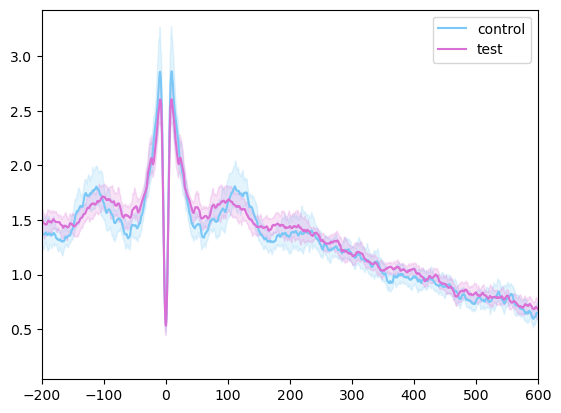

In [ ]:
val_control.shape

bins = base_merged_df.bins_control.values[0] * 1000

bins.shape, val_control.shape
for val, name in zip([val_control, val_test], ["control", "test"]):
    color = interval_style[name]
    yy, rng = bootstrap_traces(
        val,
        100,
        statistic=np.nanmedian,
        n_boot=100,
    )
    plt.plot(bins, yy, color=color, label=name)
    plt.fill_between(bins, rng[0], rng[1], color=color, alpha=0.2)
# plt.plot(bins, np.median(val_control,axis=0), alpha=1)
# plt.plot(bins, np.median(val_test,axis=0), alpha=1)
plt.xlim(-200, 600)
plt.legend()

# Autocorrelation

In [139]:
from Analysis.utils import filter_opto_data

animal = "Wallie"
params_name = "default_dlc"


dataset_key = {
    "animal": animal,
    "targeted_phase": 90,
    "track_type": "early_wtrack",
}
dataset = filter_opto_data(dataset_key)
dataset = dataset.fetch(as_dict=True)
control_dataset = []
test_dataset = []
for key in dataset:
    control_dataset.append(
        {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": key["interval_list_name"] + "_opto_control_interval",
        }
    )
    test_dataset.append(
        {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": key["interval_list_name"] + "_opto_test_interval",
        }
    )


CrossCorrelogram() & control_dataset
control_df = (CrossCorrelogram() & control_dataset).fetch_auto_correlograms()
test_df = (CrossCorrelogram() & test_dataset).fetch_auto_correlograms()
# control_df

datasets: 10


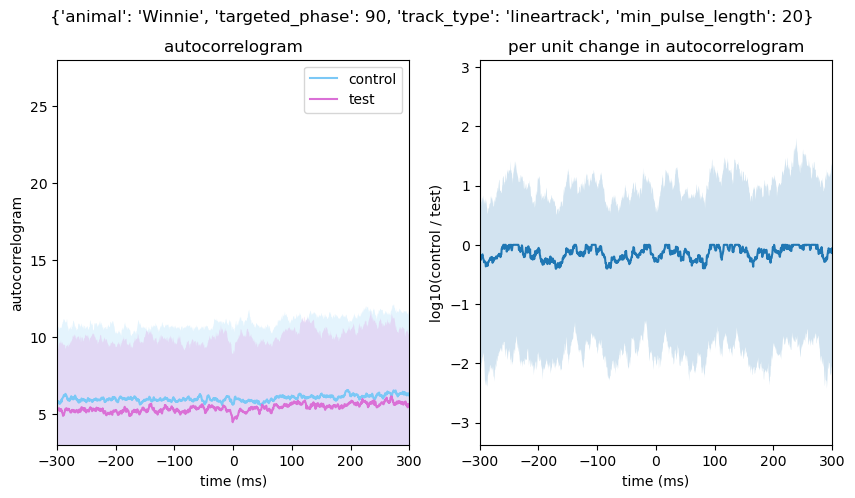

In [37]:
min_spikes = 100
max_spikes = 3000

query = (
    f"counts_1 > {min_spikes} and counts_1 < {max_spikes}"
    + f" and counts_2 > {min_spikes} and counts_2 < {max_spikes}"
)

# Apply the query to filter the DataFrame
control_plot_df = control_df.query(query)

# Filter test_df in advance to reduce the size of the DataFrame for merging
filtered_test_df = test_df.query(
    f"counts_1 > {min_spikes} and counts_1 < {max_spikes} and "
    f"counts_2 > {min_spikes} and counts_2 < {max_spikes}"
)

# Merge control_plot_df with filtered_test_df based on unit_id_1 and unit_id_2
merged_df = control_plot_df.merge(
    filtered_test_df,
    on=["unit_id_1", "unit_id_2"],
    suffixes=("_control", "_test"),
    how="inner",
)


# Calculate the differences using vectorized operations
control_vals = np.vstack(merged_df["correlogram_test"])
test_vals = np.vstack(merged_df["correlogram_control"])
# diffs = control_vals - test_vals
# diffs = np.log10(control_vals) - np.log10(test_vals)
diffs = np.log10(test_vals / control_vals)
diffs = test_vals - control_vals

# Plot the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)
for val, condition in zip([control_vals, test_vals], ["control", "test"]):
    ax[0].plot(
        bins,
        np.nanmedian(val, axis=0),
        color=interval_style[condition],
        label=condition,
    )
    lo = np.nanpercentile(val, 25, axis=0)
    hi = np.nanpercentile(val, 75, axis=0)
    ax[0].fill_between(
        bins, lo, hi, facecolor=interval_style[condition], alpha=0.2, zorder=-2
    )


# ax[0].plot(bins, np.nanmedian(control_vals, axis=0))
# ax[0].plot(bins, np.nanmedian(test_vals, axis=0))
ax[0].legend()
ax[1].plot(bins, np.nanmedian(diffs, axis=0))
ax[1].fill_between(
    bins,
    np.nanpercentile(diffs, 25, axis=0),
    np.nanpercentile(diffs, 75, axis=0),
    alpha=0.2,
)


ax[1].set_xlim(-300, 300)
# ax[1].set_ylim(-.3,.2)

ax[0].set_ylim(3, 28)
ax[0].set_ylabel("autocorrelogram")
ax[1].set_ylabel("log10(control / test)")
ax[0].set_title("autocorrelogram")
ax[1].set_title("per unit change in autocorrelogram")
for a in ax:
    a.set_xlabel("time (ms)")
fig.suptitle(dataset_key)
plt.show()

(-500.0, 500.0)

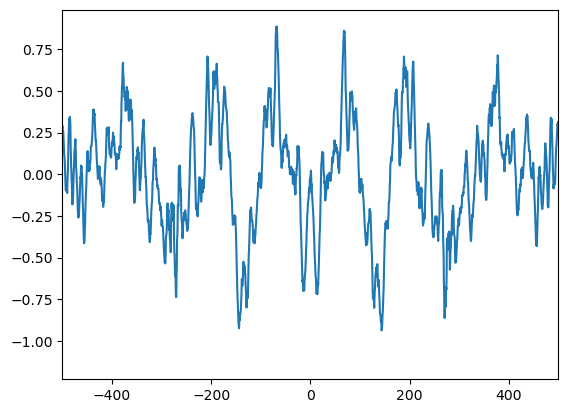

In [78]:
plt.plot(bins, np.nanmean(diffs, axis=0))
plt.xlim(-500, 500)

#### debug

In [ ]:
len(auto_corr_df)

159

In [ ]:
%load_ext autoreload
%autoreload 2
import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from Analysis.utils import get_running_valid_intervals

key = {
    "nwb_file_name": "Winnie20220719_.nwb",
    "interval_list_name": "pos 5 valid times",
}
get_running_valid_intervals(key, dlc_pos=True)

[2024-07-18 12:16:36,455][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-07-18 12:16:36,506][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


(array([[1.65826556e+09, 1.65826556e+09],
        [1.65826556e+09, 1.65826556e+09],
        [1.65826558e+09, 1.65826558e+09],
        [1.65826558e+09, 1.65826558e+09],
        [1.65826558e+09, 1.65826558e+09],
        [1.65826558e+09, 1.65826558e+09],
        [1.65826560e+09, 1.65826561e+09],
        [1.65826561e+09, 1.65826561e+09],
        [1.65826561e+09, 1.65826561e+09],
        [1.65826561e+09, 1.65826561e+09],
        [1.65826561e+09, 1.65826561e+09],
        [1.65826561e+09, 1.65826561e+09],
        [1.65826562e+09, 1.65826562e+09],
        [1.65826562e+09, 1.65826562e+09],
        [1.65826562e+09, 1.65826562e+09],
        [1.65826562e+09, 1.65826563e+09],
        [1.65826564e+09, 1.65826564e+09],
        [1.65826564e+09, 1.65826564e+09],
        [1.65826564e+09, 1.65826564e+09],
        [1.65826564e+09, 1.65826564e+09],
        [1.65826564e+09, 1.65826564e+09],
        [1.65826564e+09, 1.65826564e+09],
        [1.65826564e+09, 1.65826565e+09],
        [1.65826565e+09, 1.6582656

In [ ]:
CrossCorrelogramParameters()
CrossCorrelogram().populate()

number_units 104


104it [00:54,  1.90it/s]
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (34871, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (36413, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (31155, 6) which is not compliant with NWB 2.5 and